# Paradise Creek: A Python Tutorial

## Background

A Palouse Conservation District (PCD) employee asked me where they could find a complete shapefile for Paradise Creek. I suggested OpenStreetMap, which became a rabbit hole of how to acquire the data and turn it into a useable format. This notebook is my attempt to provide quick, clean solutions to someone with chiefly ArcPro and ArcPy experience. It assumes that the GIS packages environment is already established and that Jupyter Notebook is within the user's skillset. 

Acquiring basic data can help inform the search for erosion-prone sections of Paradise Creek, in which PCD is interested. They use geographic and environmental measures to plan restoration projects. Water and soil quality as well as community engagement are others areas where PCD relies on geospatial data.

The Python tools here are more than adequate to calculate and plot the desired data.

## Limitations

OpenStreetMap shows the origin of Paradise Creek near the intersection of Mountain View Road and Moscow Mountain Road. In actuality, the creek begins several miles farther north on Moscow Mountain. 

## Objectives

### My primary goal in this is to show how to create an elevation profile of a line shape. It ended up not working out how I expected. However, along the way, I was able to come up with solutions to other pertinent questions. 

### Solution provided:
+ the number of breaks in the OSM way "Paradise Creek" due to culverts
+ the longest stretch of uninterrupted creek
+ total length
+ elevation change from origin to termination, with an elevation profile


## Workflow:
#### 0. Import Modules
#### 1. Specify Directory Paths
#### 2. Read-in Data
+ pertinent line and elevation data
+ referential place data (county, city)

#### 3. Preview Data
#### 4. Transform/Reproject Data
#### 5. Provide solutions to the objectives
+ make a basic plot, showing the general area and features
+ perform raster and vector calculations
+ plot and/or graph results

## Data

#### Paradise Creek is 32 separate 'ways' in OSM, which flows through culverts, under bridges, and underground in both Latah and Whitman counties. To save some time in getting the creek dataset, I used the QuickOSM plugin in QGIS. 
+ First zoom to the Moscow-Pullman area
+ Quick Query  'waterway' = 'stream' by Canvas Extent 
+ select by attributes 'name' = 'Paradise Creek'
+ create new layers, with CRS EPSG:4326
    - ParadiseCreek.gpkg
    - ParadiseCreekLatah.gpkg
    - ParadiseCreekWhitman.gpkg

#### Additional data includes
+ OSM county shapes
+ Moscow vector GDB
+ palouse_hills.tif 

## 0. Import Modules

(more than are necessary for this tutorial. . . so far)

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, GeometryCollection, Point, Polygon
import matplotlib.pyplot as plt
from pathlib import Path
import fiona
# import csv
import richdem as rd
import rasterio as rio
import osmnx as ox
# import pyproj

In [2]:
# %matplotlib widget
%matplotlib inline

## 1. Specify directory paths

In [3]:
Path('.')
datasets_dir = Path('../../datasets')

In [4]:
moscow_gdb_path = datasets_dir / 'moscow' / 'moscow_vectors' / 'Moscow.gdb'

In [5]:
elev_rio = rio.open(datasets_dir / 'regional_dems' / 'palouse_hills.tif')

In [6]:
PC_path = "../../datasets/JE_FinalData/ParadiseCreek.gpkg"

## 2. Read-in data

### OSM data

In [7]:
counties = ['Latah County, Idaho', 'Whitman County, Washington']
place = ox.geocode_to_gdf(counties)

In [8]:
gpd.io.file.fiona.drvsupport.supported_drivers['GPKG'] = 'rw'

In [9]:
PC_data = gpd.read_file(PC_path)
### A runtime warning may occur with this cell on the first run. Just re-run it.

C:\Users\q\.conda\envs\GISenv21b\lib\site-packages\geopandas\geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [10]:
type(PC_data)

geopandas.geodataframe.GeoDataFrame

In [11]:
# get the Latah and Whitman sections of the creek
L_path = "../../datasets/JE_FinalData/ParadiseCreekLatah.gpkg"
W_path = "../../datasets/JE_FinalData/ParadiseCreekWhitman.gpkg"
PCLatah_data = gpd.read_file(L_path)
PCWhitman_data = gpd.read_file(W_path)

### GPD data

(these will do for now, but I would also like the Pullman streets dataset)

In [12]:
moscow_gdb = str(moscow_gdb_path)
fiona.listlayers(moscow_gdb)

['Moscow_Zoning',
 'Centerlines',
 'Moscow_Parks',
 'Moscow_City_Limit',
 'Parcels']

In [13]:
parcels = gpd.read_file(moscow_gdb, layer='Parcels')
roads = gpd.read_file(moscow_gdb, layer='Centerlines')
zoning = gpd.read_file(moscow_gdb, layer='Moscow_Zoning')
city_limits = gpd.read_file(moscow_gdb, layer='Moscow_City_Limit')
parks = gpd.read_file(moscow_gdb, layer='Moscow_Parks')

## 3. Preview what you have to work with

### OpenStreetMap data

Verifying the datastructures and the data types within them will guide you through data cleaning and analysis. Additionally, an important early step is making sure all data are projected into the same coordinate system before analysis begins.

#### The UTM 11N projection is well-suited for this area and has base units of meters. Farther below this is codified as EPSG 32611.

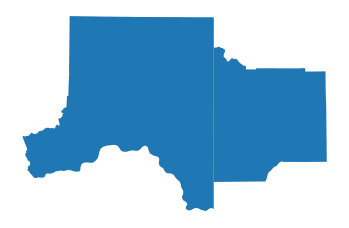

In [14]:
roi = ox.project_gdf(place)
ax = roi.plot()
_ = ax.axis('off')

In [15]:
PC_data.head()

,full_id,osm_id,osm_type,waterway,intermittent,tunnel,layer,name,geometry
0,w480119994,480119994,way,stream,None,culvert,None,Paradise Creek,"LINESTRING (-117.05935 46.73777, -117.05932 46..."
1,w480119995,480119995,way,stream,None,None,None,Paradise Creek,"LINESTRING (-117.04691 46.73239, -117.04751 46..."
2,w480120007,480120007,way,stream,None,culvert,None,Paradise Creek,"LINESTRING (-117.00449 46.72735, -117.00458 46..."
3,w480120008,480120008,way,stream,None,None,None,Paradise Creek,"LINESTRING (-116.99139 46.72250, -116.99165 46..."
4,w480120009,480120009,way,stream,None,culvert,None,Paradise Creek,"LINESTRING (-116.99093 46.72269, -116.99139 46..."


In [16]:
PC_data.geometry

0     LINESTRING (-117.05935 46.73777, -117.05932 46...
1     LINESTRING (-117.04691 46.73239, -117.04751 46...
2     LINESTRING (-117.00449 46.72735, -117.00458 46...
3     LINESTRING (-116.99139 46.72250, -116.99165 46...
4     LINESTRING (-116.99093 46.72269, -116.99139 46...
5     LINESTRING (-117.01181 46.73114, -117.01218 46...
6     LINESTRING (-117.00704 46.73003, -117.00726 46...
7     LINESTRING (-117.00668 46.72978, -117.00704 46...
8     LINESTRING (-117.00462 46.72759, -117.00505 46...
9     LINESTRING (-117.06653 46.73752, -117.06653 46...
10    LINESTRING (-117.01164 46.73109, -117.01167 46...
11    LINESTRING (-117.06653 46.73760, -117.06652 46...
12    LINESTRING (-117.09486 46.72939, -117.09492 46...
13    LINESTRING (-117.09492 46.72946, -117.09497 46...
14    LINESTRING (-117.05932 46.73765, -117.05929 46...
15    LINESTRING (-117.14409 46.72148, -117.14423 46...
16    LINESTRING (-117.16384 46.72048, -117.16391 46...
17    LINESTRING (-117.16252 46.72055, -117.1638

In [17]:
PC_data.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### GPD data

In [18]:
zoning.head()

,LANDUSECODE,LANDUSEDESC,BASEELEV,HEIGHT,LASTUPDATE,LASTEDITOR,SUBTYPECODE,SUBTYPEDESC,PARCELID,ADDRESS,LOCDESC,GlobalID,SHAPE_Length,SHAPE_Area,geometry
0,111,Auto-Urban Residential,None,None,2017-01-01T00:00:00+00:00,None,None,Single Family Residential,RPM11000010040,856 N Garfield St,,{D1CDFE80-F20E-4A7F-A6FE-61F956BA3ABF},1259.873360,72225.370599,MULTIPOLYGON Z (((2314900.119 1852432.172 0.00...
1,750,University,None,None,2017-01-01T00:00:00+00:00,None,None,Public Parking,RPM1110002001A,725 W Sixth St LOT 15,,{037ACFD7-39A7-4F64-85F1-4CD9B4B556E0},495.250762,14883.271878,MULTIPOLYGON Z (((2308808.447 1848161.226 0.00...
2,750,University,None,None,2017-01-01T00:00:00+00:00,None,None,Public Parking,RPM11100010050,618 Ash St LOT 16,,{8EA5F61E-2673-4CFF-BB74-E88A6E7CD452},320.000003,4800.000103,MULTIPOLYGON Z (((2308964.486 1847976.075 0.00...
3,750,University,None,None,2017-01-01T00:00:00+00:00,None,None,Public Parking,RPM1110001006A,622 Ash St LOT 16,,{4847C34D-9D8D-4131-95EE-3B094B4A77DB},440.000004,12000.000546,MULTIPOLYGON Z (((2308962.799 1847876.089 0.00...
4,750,University,None,None,2017-01-01T00:00:00+00:00,None,None,Public Parking,RPM1110001009A,630 Ash St LOT 16,,{83339838-B907-4C77-B2D1-20BE22846523},346.905350,6397.201123,MULTIPOLYGON Z (((2308842.478 1847858.117 0.00...


In [19]:
zoning.crs # change this to EPSG:32611

<Projected CRS: EPSG:2243>
Name: NAD83 / Idaho West (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - Idaho - counties of Ada; Adams; Benewah; Boise; Bonner; Boundary; Canyon; Clearwater; Elmore; Gem; Idaho; Kootenai; Latah; Lewis; Nez Perce; Owyhee; Payette; Shoshone; Valley; Washington.
- bounds: (-117.24, 41.99, -114.32, 49.01)
Coordinate Operation:
- name: SPCS83 Idaho West zone (US Survey feet)
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### DEM data

In [20]:
elev = elev_rio.read(1) #this reader pulls out one band of info, puts it into a nparray
elev[elev<-1000] = np.nan

In [21]:
elev

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [22]:
print("The CRS of the .tif is: ", elev_rio.crs) # You will want to change this to EPSG:32611 too.
elev_rio.transform # The `transform` orients the raster grid in space relative to the crs.
    # The crs contains the units and identifies where the (0, 0) point of the grid ought to be in space.

The CRS of the .tif is:  EPSG:4269


Affine(9.259259284609841e-05, 0.0, -117.29564814622064,
       0.0, -9.259259284609902e-05, 46.83527777766481)

In [23]:
dx = elev_rio.transform[0] # grid resolution in Easting (x)
rast_x = elev_rio.transform[2] + dx * np.arange(elev_rio.width)
dy = elev_rio.transform[4] # grid resolution in Northing (y)
rast_y = elev_rio.transform[5] + dy * np.arange(elev_rio.height)

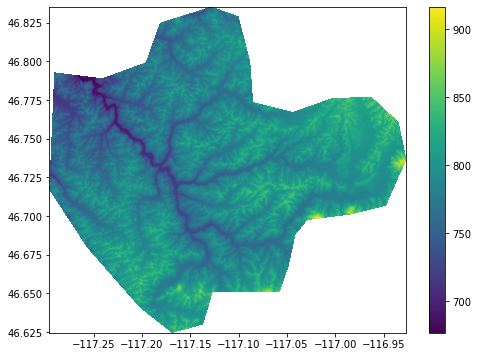

In [24]:
fig, ax = plt.subplots(figsize=(8,6))
elev_ax = ax.pcolormesh(rast_x, rast_y, elev, shading='auto')
plt.colorbar(elev_ax, ax=ax)

## 4. Transform/reproject datasets into a single CRS. 

### Reproject the vector data.

#### Using the longitude and latitude in the map extent above, assign these values to variables.

In [25]:
x_long, y_lat = -117, 46

In [26]:

def UTMConvert(g, x_long, y_lat):
    dataEPSG = int(32700 - ((np.sign(y_lat) + 1)/2 * 100) +  (np.floor((180 + x_long)/6) + 1))
    return g.to_crs(epsg=dataEPSG)

In [27]:
PC_meters = UTMConvert(PC_data, x_long, y_lat)

In [28]:
PC_meters.head()

,full_id,osm_id,osm_type,waterway,intermittent,tunnel,layer,name,geometry
0,w480119994,480119994,way,stream,None,culvert,None,Paradise Creek,"LINESTRING (495465.907 5176025.300, 495468.204..."
1,w480119995,480119995,way,stream,None,None,None,Paradise Creek,"LINESTRING (496415.674 5175427.204, 496369.936..."
2,w480120007,480120007,way,stream,None,culvert,None,Paradise Creek,"LINESTRING (499656.989 5174865.917, 499649.968..."
3,w480120008,480120008,way,stream,None,None,None,Paradise Creek,"LINESTRING (500658.000 5174327.751, 500637.917..."
4,w480120009,480120009,way,stream,None,culvert,None,Paradise Creek,"LINESTRING (500693.348 5174348.401, 500658.000..."


In [29]:
PC_meters.crs # to verify the change

<Projected CRS: EPSG:32611>
Name: WGS 84 / UTM zone 11N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 120°W and 114°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Alberta; British Columbia (BC); Northwest Territories (NWT); Nunavut. Mexico. United States (USA).
- bounds: (-120.0, 0.0, -114.0, 84.0)
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [30]:
EPSG = 32611 # assign this variable to be used later

### Reproject the raster data.

### First prepare the data by changing its type to fit the richdem module which will spatially orient it.

In [31]:
elev_rd = rd.rdarray(elev, no_data=np.nan) 
elev_rd.projection = elev_rio.crs
# Be careful!  The richdem geotransform has a different configuration than the rasterio transform.
    # The geotransform must be a tuple.
elev_rd.geotransform = (elev_rio.transform[2],
                        elev_rio.transform[0],
                        elev_rio.transform[1],
                        elev_rio.transform[5],
                        elev_rio.transform[3],
                        elev_rio.transform[4])

In [32]:
elev_rd.projection

CRS.from_epsg(4269)

In [33]:
elev_rd.geotransform

(-117.29564814622064,
 9.259259284609841e-05,
 0.0,
 46.83527777766481,
 0.0,
 -9.259259284609902e-05)

### Define a function to facilitate this change

In [34]:
def reproject_basic(input_file, output_file, dst_crs):
    '''
    Takes one raster file (input_file) and transforms it to a new crs identified by EPSG (as in dst_crs='EPSG:4326')
    and saves it as a new raster (output_file).
    '''
    import numpy as np
    import rasterio
    from rasterio.warp import calculate_default_transform, reproject, Resampling
    
    #Read in the input_file and prep it to be warped
    with rasterio.open(input_file) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })
        
        # Write out the output, reprojected file
        with rasterio.open(output_file, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

### Now, run the function with the specific arguments:

In [35]:
reproject_basic('../../datasets/regional_dems/palouse_hills.tif',
                '../../datasets/regional_dems/palouse_hills_' + str(EPSG) + '.tif',
                'EPSG: ' + str(EPSG) )

### Assign this file to a variable name for the next step:

### Read in the new, reprojected DEM:

In [36]:
elev_rio_reproject = rio.open('../../datasets/regional_dems/palouse_hills_' + str(EPSG) + '.tif')
elev_reproject = elev_rio_reproject.read(1)
elev_reproject[elev_reproject<-1000] = np.nan

In [37]:
elev_rd_reproject = rd.rdarray(elev_reproject, no_data=np.nan) # Need to turn the elevations from a numpy array to an rdarray to handle the np.nan values
elev_rd_reproject.projection = elev_rio_reproject.crs
# Be careful!  The richdem geotransform has a different configuration than the rasterio transform.
    # The geotransform must be a tuple.
elev_rd_reproject.geotransform = (elev_rio_reproject.transform[2],
                        elev_rio_reproject.transform[0],
                        elev_rio_reproject.transform[1],
                        elev_rio_reproject.transform[5],
                        elev_rio_reproject.transform[3],
                        elev_rio_reproject.transform[4])


### Verify the richdem geotransform, you will see the decimal degree units have changed to meters.

In [38]:
elev_rio_reproject.crs

CRS.from_epsg(32611)

In [39]:
elev_rio_reproject.transform

Affine(7.985279909359203, 0.0, 477366.0719509967,
       0.0, -7.985279909359203, 5186901.591923617)

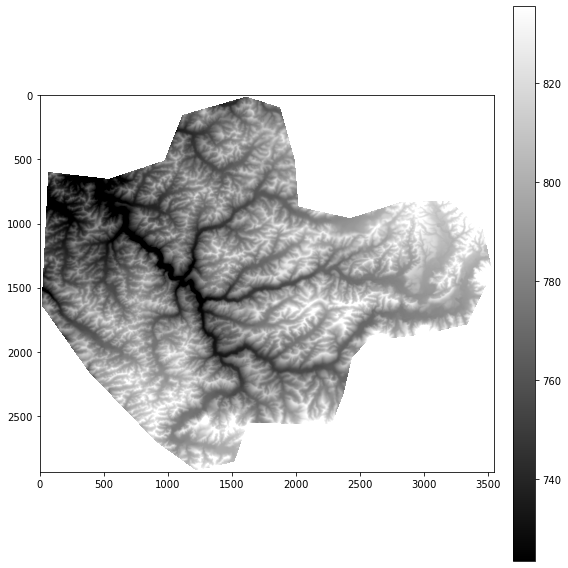

{'vmin': 723.4743041992188, 'vmax': 835.545654296875}

In [40]:
# elev_reproject = rd.TerrainAttribute(elev_rd_reproject, attrib='')
rd.rdShow(elev_rd_reproject, figsize=(8,8))

In [41]:
dx = elev_rio_reproject.transform[0] # grid resolution in Easting (x)
rast_x = elev_rio_reproject.transform[2] + dx * np.arange(elev_rio_reproject.width)
dy = elev_rio_reproject.transform[4] # grid resolution in Northing (y)
rast_y = elev_rio_reproject.transform[5] + dy * np.arange(elev_rio_reproject.height)

### Using the view extent from the bookmark in QGIS, you can "zoom in" on the area of interest.

In [42]:
extent = np.array([5168534.2518, 485094.8944, 5184742.9916, 506938.7355])

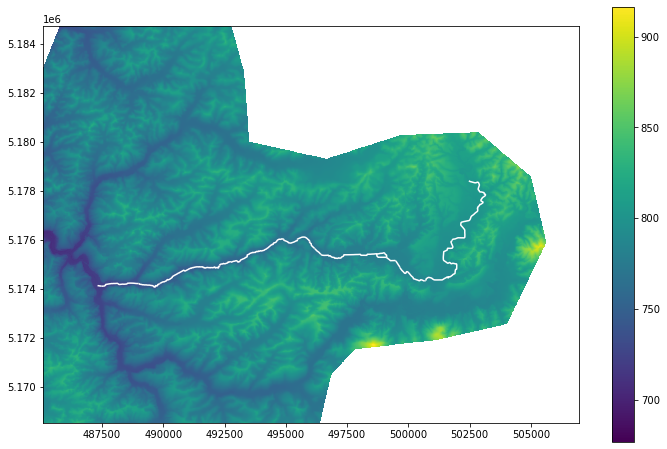

In [43]:
fig, ax = plt.subplots(figsize=(12,8))

xlim = ([extent[1],  extent[3]])
ylim = ([extent[0],  extent[2]])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

PC_meters.plot(ax=ax, facecolor='none', edgecolor='w', lw=1.5) 
elev_reproject_ax = ax.pcolormesh(rast_x, rast_y, elev_reproject, shading='auto')
plt.colorbar(elev_reproject_ax, ax=ax)


### If you would like to create an elevation profile of Paradise Creek, you will have to change the geometry of the dataset from linestrings to points.

In [44]:

PC_meters['points'] = PC_meters.apply(lambda x: [y for y in x['geometry'].coords], axis=1)

In [45]:
PC_meters.head()

,full_id,osm_id,osm_type,waterway,intermittent,tunnel,layer,name,geometry,points
0,w480119994,480119994,way,stream,None,culvert,None,Paradise Creek,"LINESTRING (495465.907 5176025.300, 495468.204...","[(495465.90665706707, 5176025.299650722), (495..."
1,w480119995,480119995,way,stream,None,None,None,Paradise Creek,"LINESTRING (496415.674 5175427.204, 496369.936...","[(496415.67382280156, 5175427.203776035), (496..."
2,w480120007,480120007,way,stream,None,culvert,None,Paradise Creek,"LINESTRING (499656.989 5174865.917, 499649.968...","[(499656.98896200483, 5174865.916906052), (499..."
3,w480120008,480120008,way,stream,None,None,None,Paradise Creek,"LINESTRING (500658.000 5174327.751, 500637.917...","[(500657.9997514943, 5174327.75073979), (50063..."
4,w480120009,480120009,way,stream,None,culvert,None,Paradise Creek,"LINESTRING (500693.348 5174348.401, 500658.000...","[(500693.34847564716, 5174348.400986368), (500..."


### Notice that the points are not yet usable. They are an array of lists of tuples. A few more steps are required to get coordinate pairs.

In [46]:
type(PC_meters.points[0])

list

In [47]:
elev_m = PC_meters.points.to_numpy()

In [48]:
xy_pairs = []
for sublist in elev_m:
    for item in sublist:
        xy_pairs.append(item)

### Now you have coordinate pairs for each point but these will be more useable as separate longitude and latitude arrays.

In [49]:
xy_pairs[0]

(495465.90665706707, 5176025.299650722)

In [50]:
len(xy_pairs) # there are this many of them

953

In [51]:
type(xy_pairs)

list

In [52]:
type(xy_pairs[1])

tuple

In [53]:
for i in range(len(xy_pairs)):
    xy_pairs[i] = np.asarray(xy_pairs[i])

In [54]:
profile = np.array(xy_pairs)

In [55]:
profile

array([[ 495465.90665707, 5176025.29965072],
       [ 495468.20382715, 5176012.01892095],
       [ 496415.6738228 , 5175427.20377604],
       ...,
       [ 489897.13123053, 5174247.65920067],
       [ 489878.42472948, 5174234.64502007],
       [ 489871.70642631, 5174229.51141697]])

In [56]:
x = []
y = []

In [57]:
for idx in profile:
    x.append(idx[0])
    y.append(idx[1])

In [58]:
longitude = np.array(x)
latitude = np.array(y)

In [59]:
sample = []

### Now that you have the point coordinates from the shape of Paradise Creek, you can extract its elevations from the raster.

In [60]:
for i in range(len(longitude)):
    for val in elev_rio_reproject.sample([(longitude[i], latitude[i])]):
        sample.append(val)

### But look, you'll want just the float values out of this array:

In [61]:
sample[0]

array([767.88696], dtype=float32)

In [62]:
type(sample[0])

numpy.ndarray

In [63]:
elev_profile = []

In [64]:
for val in sample:
    for elev in val:
        elev_profile.append(elev)

In [65]:
elev_profile = np.array(elev_profile)

### Now you have them.

In [66]:
elev_profile[0]

767.88696

### To plot the elevation profile along the course of the creek, (rather than a straight-line distance based on longitude and latitude) you will need to find the linear distance between each point.

In [67]:
dist_xy = np.sqrt(np.diff(longitude)**2 + np.diff(latitude)**2)

In [68]:
len(dist_xy)

952

### Add an initial distance of 0 for the starting point.

In [69]:
dist_xy = np.insert(dist_xy, 0, 0, axis=0)

### Next, by accumulating the total distance of each point from the origin you can make a linear plot.

In [70]:
dist = 0
dist_m = []

In [71]:
for val in dist_xy:
    dist = dist + val - dist_xy[0]
    dist_m.append(dist)

In [72]:
dist_m[0:4]

[0.0, 13.477936553424996, 1126.899755261643, 1192.4006725476063]

In [73]:
dist_m[-1]-dist_m[0]

127205.14079183666

### This would be the total disance from the origin, but it is 5x longer than the actual length of the creek. I believe that error lies in the order of the points. When reducing the linestring to coordinate pairs, the order of the points is not preservered so the measured distances are not between sequential points along the creek. Therefore my methodology doesn't work. The plot verifies the same.

### Now with the dimensions gathered above, you can arrange them and plot the profile.

In [74]:
long_df = pd.DataFrame(longitude, columns = ["longitude"])
elev_df = pd.DataFrame(elev_profile, columns = ["elevation"])
lat_df = pd.DataFrame(latitude, columns = ["latitude"])
dist_df = pd.DataFrame(dist_m, columns = ["distance"])

In [75]:
elev_plot = pd.concat([long_df, elev_df, lat_df, dist_df], axis = 1)
# elev_plot = pd.concat([long_df, elev_df, lat_df], axis = 1)


In [76]:
elev_plot

,longitude,elevation,latitude,distance
0,495465.906657,767.886963,5.176025e+06,0.000000
1,495468.203827,767.886963,5.176012e+06,13.477937
2,496415.673823,771.599365,5.175427e+06,1126.899755
3,496369.935919,771.229370,5.175474e+06,1192.400673
4,496340.180640,769.483521,5.175506e+06,1235.844521
...,...,...,...,...
948,489944.957662,745.351624,5.174272e+06,127120.040462
949,489925.184152,745.979553,5.174261e+06,127142.871022
950,489897.131231,745.345520,5.174248e+06,127173.897446
951,489878.424729,744.796448,5.174235e+06,127196.685647


In [77]:
m_long = elev_plot["longitude"].to_numpy()
m_elev = elev_plot["elevation"].to_numpy()
m_dist = elev_plot["distance"].to_numpy()
m_lat = elev_plot["latitude"].to_numpy()

## Unfortunately, this first plot is where I realized my methodology wouldn't work. That is one ambitious stream.

Text(0.5, 1.0, 'Elevation Profile of Pardise Creek')

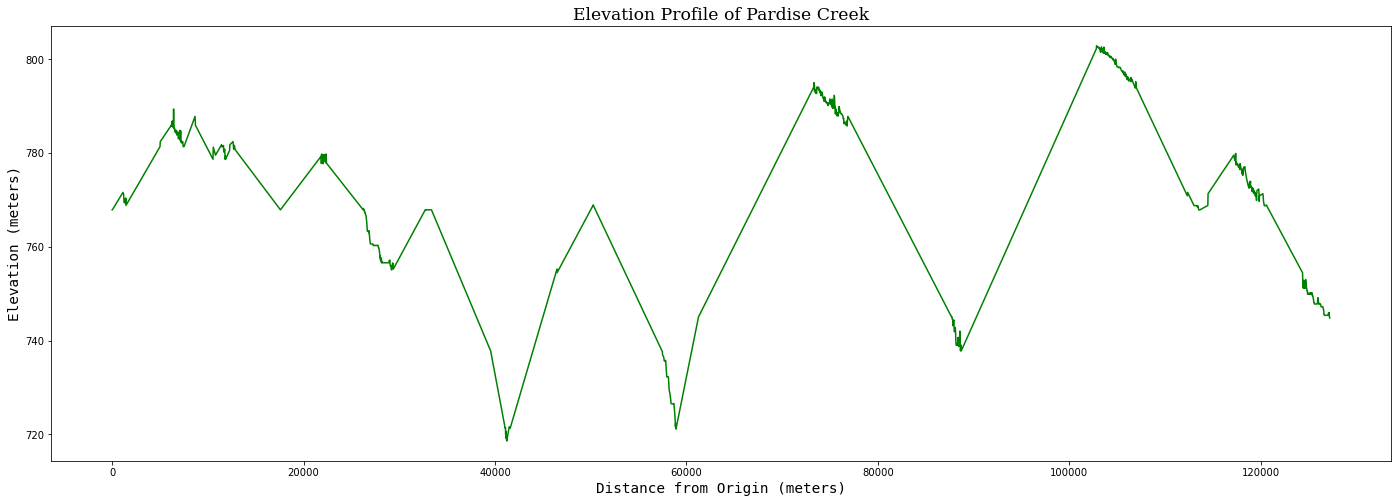

In [78]:
### Oh no. . .
%matplotlib inline
fig, ax = plt.subplots(figsize=(24,8))
### try also as scatter plot to see reveal the spacing and potential errors in the coordinates  
# ax.plot(m_dist, m_elev,  color = 'green')
ax.plot(m_dist, m_elev,  color = 'green')
ax.set_xlabel('Distance from Origin (meters)', fontsize = 'x-large', family = 'monospace')
ax.set_ylabel('Elevation (meters)', fontsize = 'x-large', family = 'monospace')
ax.set_title('Elevation Profile of Pardise Creek', fontsize = 'xx-large', family = 'serif')

## This plot below in an acceptable compromise. It shows the elevation profile on a strict east to west view. The fluctuations, of course, are due to the stream meandering E/W along its ultimate flow westward. 

In [79]:
elev_sort = elev_plot.sort_values(by = ["longitude"]) 

In [80]:
sort_long = elev_sort["longitude"].to_numpy()
sort_elev = elev_sort["elevation"].to_numpy()
sort_dist = elev_sort["distance"].to_numpy()
sort_lat = elev_sort["latitude"].to_numpy()

Text(0.5, 1.0, 'Elevation Profile of Pardise Creek')

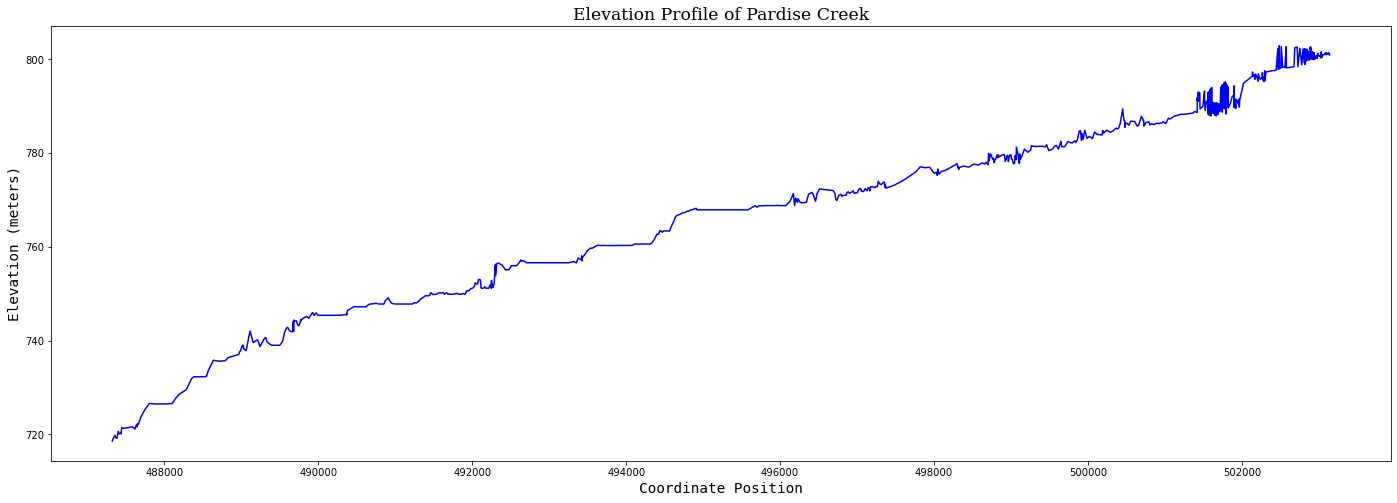

In [82]:
### KEEP
%matplotlib inline
fig, ax = plt.subplots(figsize=(24,8))

# ax.scatter(sort_long, sort_elev,  color = 'blue')
ax.plot(sort_long, sort_elev,  color = 'blue')
ax.set_xlabel('Coordinate Position', fontsize = 'x-large', family = 'monospace')
ax.set_ylabel('Elevation (meters)', fontsize = 'x-large', family = 'monospace')
ax.set_title('Elevation Profile of Pardise Creek', fontsize = 'xx-large', family = 'serif')

## Moving on from the elevation profile, some additional work needs to be done to the county-specific data. A section of the creek that crosses the state line is present in both datasets. In order to make a valid comparision between the Whitman and Latah sections you will first need to clip the creek to the border.

In [83]:
# be aware that the section of the creek that crosses the stateline exists in both GDF, you can clip this by county
Whitman = ox.geocode_to_gdf("Whitman County, Washington")
Latah = ox.geocode_to_gdf("Latah County, Idaho")

In [103]:
Latah = Latah.to_crs(epsg=32611)
Whitman = Whitman.to_crs(epsg=32611)

In [104]:
PCLatah_data = PCLatah_data.to_crs(epsg=32611)
# PCLatah_data.crs

In [105]:
Latah_len = sum(PCLatah_data.length.to_numpy())

In [106]:
Latah_len

13332.877791216986

In [107]:
PCWhitman_data = PCWhitman_data.to_crs(epsg=32611)
# PCWhitman_data.crs

In [108]:
Whitman_len = sum(PCWhitman_data.length.to_numpy())

In [109]:
Whitman_len

13469.43117845722

<AxesSubplot:>

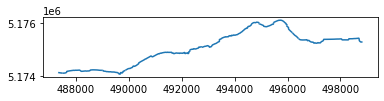

In [110]:
PCWhitman_data.plot()

In [111]:
PC_Whitman = gpd.clip(PCWhitman_data, Whitman)

<AxesSubplot:>

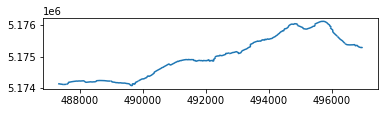

In [112]:
PC_Whitman.plot() # exclusively inside Whitman county

<AxesSubplot:>

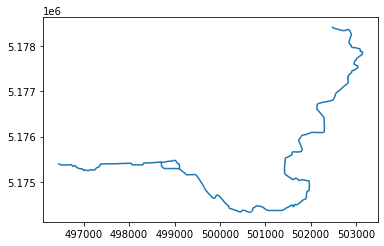

In [113]:
PCLatah_data.plot() 

In [114]:
PC_Latah = gpd.clip(PCLatah_data, Latah)

<AxesSubplot:>

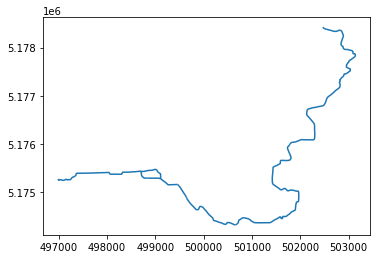

In [115]:
PC_Latah.plot() # exclusively inside Latah county

In [116]:
PC_meters.length

0       13.477937
1      312.530221
2       29.047227
3     1318.966848
4       40.938551
5      262.118408
6      409.328227
7       38.725081
8      290.006525
9        9.316977
10     553.178306
11    2628.962930
12       8.294421
13     519.575265
14     647.574962
15      11.062127
16     162.200360
17     101.183249
18       6.167668
19      17.021755
20    1464.297268
21      15.539016
22    3561.428634
23    1009.244102
24    4121.744744
25      22.311490
26      28.328589
27     621.983345
28      23.107660
29    2685.083752
30     348.777301
31    2835.702274
dtype: float64

In [117]:
stretch = PC_meters.length.to_numpy()

In [118]:
stretch.sum()

24117.225218004496

# Summary

## 5. Provide Solutions 

In [119]:
print("From this data, there are" , PC_data[PC_data["tunnel"] == "culvert"]["tunnel"].count(), "culverts through which Paradise Creek flows.")

From this data, there are 15 culverts through which Paradise Creek flows.


In [120]:
print("The longest stretch of Paradise Creek uninterrupted by a culvert is", round(stretch.max(), 2), " meters.")

The longest stretch of Paradise Creek uninterrupted by a culvert is 4121.74  meters.


In [121]:
print("The total length of Paradise Creek within this dataset is", round(stretch.sum()/1000, 2), "kilometers.")

The total length of Paradise Creek within this dataset is 24.12 kilometers.


In [122]:
print("The total length in Latah County is", round(Latah_len/1000, 2), "kilometers.")

The total length in Latah County is 13.33 kilometers.


In [123]:
print("The total length in Whitman County  is", round(Whitman_len/1000, 2), "kilometers.")

The total length in Whitman County  is 13.47 kilometers.


### With further work any of the following could be answered as well:
+ the typical orientation of the creek
+ volume of flow under bridges vs. through culverts, where flow may be restricted and lead to flooding upstream
+ typical, greatest, or least slope in the creek
+ land usage along the creek (with the Zoning dataframe, or other), which can inform overall water quality, and erosion impact
+ compare Latah County to Whitman County creek sections in terms of zoning, human interference in flow